## Forward Longitudinal Vehicle Model
----

The model accepts throttle inputs and steps through the longitudinal dynamic equations. Once implemented, you will be given a set of inputs that drives over a small road slope to test your model.

### Input to Model

Is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

### Dynamic Equations

Consist of many stages to convert throttle inputs to wheel speed: 

\begin{align}
(Engine  -> Torque Converter  -> Transmission  -> Wheel)
\end{align}

#### 1. Engine Dynamic Equation
These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

#### 2. Engine Torque
It is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}


Where,

$T_e$ - Engine Torque

$GR$ - Gear Ratio

$r_{eff}$  - Effective Radius

$m$ - Vehicle Mass

$x$  - Vehicle Position

$F_x$ - Tire Force

$F_{load}$ - Total Load Force 

#### 3. Load Forces

 The load force models can be defined as:

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}


The load forces consist of:

$F_{aero}$ - Aerodynamic Drag

$R_x$ - Rolling Friction 

$F_g$ - Gravitational Force from an incline at angle $\alpha$


**Note**: 
1. Absolute value is ignored for friction since the model is used for **only forward motion** ($\dot{x} \ge 0$). 
2. Aerodynamic drag is a quadratic model.
3. Friction is a linear model.
 
#### 4. Tire Force

Computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where,

$\omega_w$ - Wheel Angular Velocity

$s$ - Slip Ratio


### Initial Conditions
Longitudinal model is set up inside a Python class below. 

1. Initial Velocity = 5 m/s 
2. Engine Speed = 100 rad/s
3. Sampling Time = 10ms is used for numerical integration.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.x_dot = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.x_dot = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

Implementing the combined engine dynamic equations along with the force equations. 

The function $\textit{ODE}$ takes input:
1. Throttle ($x_\theta$)
2. Incline Angle ($\alpha$)

Performs numerical integration over one timestep to update the state variables.

**Hint:** Integrate to find the current position, velocity, and engine speed first, then propagate those values into the set of equations.

In [54]:
class Vehicle(Vehicle):
    def ODE(self, throttle, alpha):
        # ==================================
        #  Vehicle model here
        # ==================================
        # For implementing the Differential Equations
        
         
        Te = throttle * (self.a_0 + (self.a_1*self.w_e) + (self.a_2 * (self.w_e*self.w_e)))
        
        F_aero = (self.c_a * (self.x_dot*self.x_dot))
        R_x = (self.c_r1 * self.x_dot)
        F_g = (self.m * self.g * np.sin(alpha))
        FLoad = F_aero + R_x + F_g
        
        w_w = (self.GR * self.w_e)
        s = (w_w * self.r_e - self.x_dot) / (self.x_dot)
        if abs(s) < 1:
            F_x = self.c * s
        else:
            F_x = self.F_max
        
        self.w_e_dot = (Te - (self.GR * self.r_e * FLoad)) / self.J_e
        self.a = (F_x - FLoad) / self.m
                                    
                
        # The equations need to be updated with sampling time
        # Dist = velo*t + (0.5*accel*t^2)
        self.x += (self.x_dot * self.sample_time) + (0.5* self.a * (self.sample_time*self.sample_time))
        # Velocity = accel*time
        self.x_dot += self.a * self.sample_time
        self.w_e += self.w_e_dot * self.sample_time

Using the model:
1. You can send constant throttle inputs to the vehicle.
2. Observe that the velocity converges to a fixed value based on the throttle input due to the aerodynamic drag and tire force limit.
3. A similar velocity profile can be seen by setting incline angle **$\alpha$ < 0**. In this case, gravity accelerates the vehicle to a terminal velocity where it is balanced by the drag force.

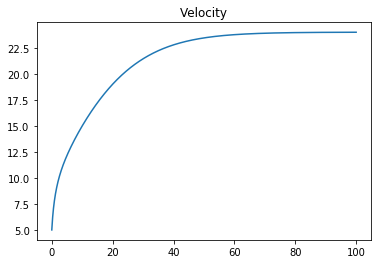

In [55]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.x_dot
    model.ODE(throttle, alpha)

plt.title('Velocity')
plt.plot(t_data, v_data)
plt.show()

## Objective

Drive the vehicle over a slope as shown in the diagram below.

![ramp](ramp.png)

## Throttle Input for Slope

A trapezoidal throttle input is provided for the next **20 sec** as shown in the figure below. 

1. Vehicle begins at 20% throttle 
2. Gradually increases to 50% throttle

This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

![throttle](throttle.png)

Implement the following and step them through the vehicle dynamics:

1. Ramp Angle Profile $\alpha (x)$ 

2. Throttle profile $x_\theta (t)$ 

The vehicle position $x(t)$ is saved in the array $\textit{x_data}$.


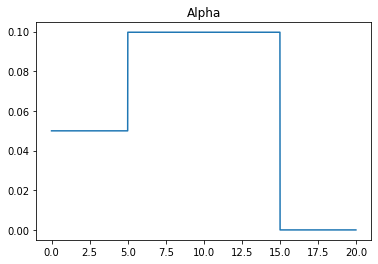

In [56]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)

# reset the states
model.reset()

# ==================================
#  Learner solution begins here
# ==================================
# We need to calculate the angle alpha for heights 3 and 12 meters high 
# alpha = arctan(3/60) for a height of 3 m
# alpha = arctan(12/60) for a height of 12 m
# WE will need to create empty arrays for alpha and throttle of size  0 to total time steps

alpha = np.zeros_like(t_data)
throttle = np.zeros_like(t_data)

# In order to give the set command throttle we need to fill the throttle and the alpha angle
# arrays and then sent that signal to the model

# Constructing Signal for Alpha

for i in range (Total_Time_Steps):
        if 0 <= t_data[i] <= 5:
            alpha[i] = np.arctan(3/60)
                        
        elif 5 <= t_data[i] <= 15:
            alpha[i] = np.arctan(9/90)
            
        else: alpha[i] = 0

plt.title('Alpha')
plt.plot(t_data, alpha)
plt.show()

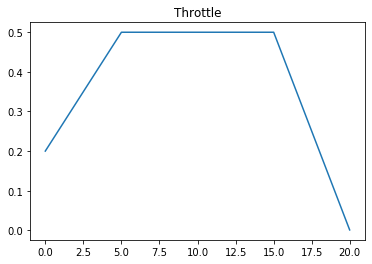

In [57]:
# Constructing Throttle Signal
# 20 sec we have 2000 steps, 
# 0-5sec: We are going from 20% to 50%
# 5-15sec: We are at 50% constant
# 15-20sec: We are decreasing from 50% to 0%
# For throttle we use the equation of line (y2-y1)/(x2-x1)*time + offset

Total_Time_Steps = t_data.shape[0]

for i in range (Total_Time_Steps):
        if 0 <= t_data[i] <= 5:
            throttle[i] = 0.2+((0.5-0.2)/(5-0))*t_data[i]
                        
        elif 5 <= t_data[i] <= 15:
            throttle[i] = 0.5
            
        elif 15 <= t_data[i] <= 20:
            throttle[i] = 2 + ((0.5-0)/(15-20))*(t_data[i])
            
plt.title('Throttle')
plt.plot(t_data, throttle)
plt.show()       

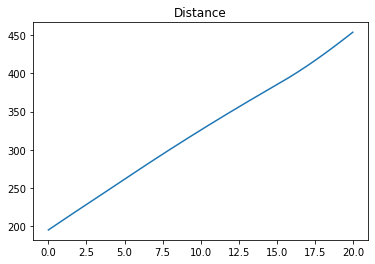

In [59]:
# Passing the Alpha and Throttle Inputs to the ODE 
    
for i in range(Total_Time_Steps):
    model.ODE(throttle[i], alpha[i])
    x_data[i] = model.x
    v_data[i] = model.x_dot
    
# ==================================
#  Learner solution ends here
# ==================================

# Plot x vs t for visualization
plt.title('Distance')
plt.plot(t_data, x_data)
plt.show()
#plt.title('Velocity')
#plt.plot(t_data, v_data)
#plt.show()


If you have implemented the vehicle model and inputs correctly, you should see that the vehicle crosses the ramp at ~15s where the throttle input begins to decrease.

The cell below will save the time and vehicle inputs as text file named $\textit{xdata.txt}$. To locate the file, change the end of your web directory to $\textit{/notebooks/Course_1_Module_4/xdata.txt}$

Once you are there, you can download the file and submit to the Coursera grader to complete this assessment.

In [60]:
data = np.vstack([t_data, x_data]).T
np.savetxt('xdata.txt', data, delimiter=', ')